## Scanpy for morphological data

We try to use scanpy to analyze morphological data from CellProfiler outputs.
An example pipeline is explained here and is used as template for this notebook:
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad


We load data from an time-lapse experiment with single-cell morphological features.
Cardiomyocytes have been cultured in 96-well plates and treated with different probes.
They were stained with a fluorescent marker for live cells and imaged at certain time points
with a high-throughput microscope.
Next, the images were analyzed with the software CellProfiler to store morphological
features for every cell.
The data is already stored in .h5ad format to make them available as to anndata.
To reduce memory we just open a subsample of all cells with 10% of all cells per well.


In [2]:
# parse config file
with open('../config.yml', 'r') as f:
    cfg = yaml.safe_load(f)

input = cfg['input']
output = cfg['output']

In [3]:
adata = ad.read_h5ad(os.path.join(output, 'morph_data_ss_10.h5ad'))
adata

AnnData object with n_obs × n_vars = 3830 × 407
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neig

### Drop invalid features

In [4]:
from morphelia.preprocessing import *

adata = drop_nan(adata, verbose=True)
adata = drop_duplicates(adata, verbose=True)
adata = drop_all_equal(adata, verbose=True)

Dropped NaN containing variables: ['Cells_AreaShape_NormalizedMoment_0_0', 'Cells_AreaShape_NormalizedMoment_0_1', 'Cells_AreaShape_NormalizedMoment_1_0']
Dropped duplicated features: Index(['Cells_AreaShape_CentralMoment_0_0',
       'Cells_AreaShape_InertiaTensor_1_0',
       'Cells_AreaShape_SpatialMoment_0_0', 'Cells_Granularity_10_CalceinAM.1',
       'Cells_Granularity_11_CalceinAM.1', 'Cells_Granularity_12_CalceinAM.1',
       'Cells_Granularity_13_CalceinAM.1', 'Cells_Granularity_14_CalceinAM.1',
       'Cells_Granularity_15_CalceinAM.1', 'Cells_Granularity_16_CalceinAM.1',
       'Cells_Granularity_17_CalceinAM.1', 'Cells_Granularity_18_CalceinAM.1',
       'Cells_Granularity_19_CalceinAM.1', 'Cells_Granularity_1_CalceinAM.1',
       'Cells_Granularity_20_CalceinAM.1', 'Cells_Granularity_21_CalceinAM.1',
       'Cells_Granularity_22_CalceinAM.1', 'Cells_Granularity_23_CalceinAM.1',
       'Cells_Granularity_24_CalceinAM.1', 'Cells_Granularity_25_CalceinAM.1',
       'Cells_Gra

In [5]:
adata

View of AnnData object with n_obs × n_vars = 3830 × 367
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Ce

The outputs shows that we have an annotated dataset with 3830 cells and
367 features.

### Preprocessing

Remove outlier cells with very high or low values for size
or intesity. This is probably due to segmentation errors or dead cells.

In [6]:
shape = [s for s in adata.var.index if 'Cells_AreaShape_Area' in s][0]
intens = [s for s in adata.var.index if 'Intensity_MedianIntensity_' in s][0]

print(shape)
print(intens)

Cells_AreaShape_Area
Cells_Intensity_MedianIntensity_CalceinAM


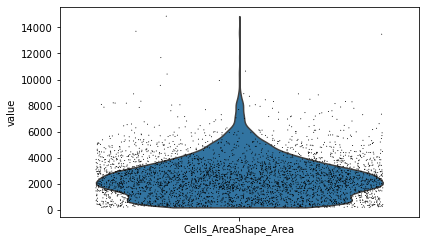

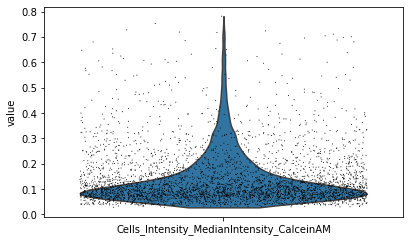

In [7]:
sc.pl.violin(adata, shape,
             jitter=0.4)
sc.pl.violin(adata, intens, jitter=0.4)

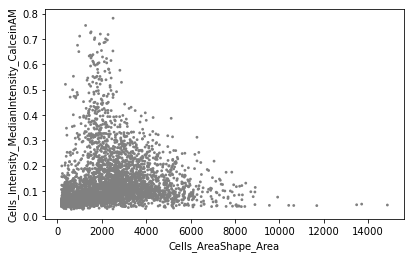

In [8]:
sc.pl.scatter(adata, x=shape, y=intens)

In [9]:
adata = filter_thresh(adata, shape, thresh=10000)
adata = filter_thresh(adata, intens, thresh=0.8)

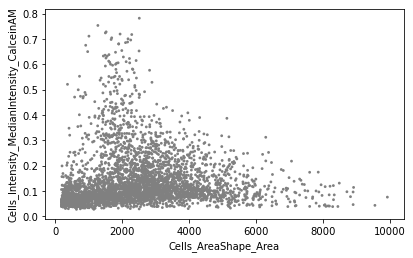

In [10]:
sc.pl.scatter(adata, x=shape, y=intens)

### Logarithmize and scale the data.

In [11]:
adata = min_max_scaler(adata)
sc.pp.log1p(adata)

C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\scanpy\preprocessing\_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
adata = drop_nan(adata, verbose=True)
adata = drop_all_equal(adata, verbose=True)

Dropped uniform features: Index([], dtype='object')


### Drop highly correlated features

In [13]:
adata

View of AnnData object with n_obs × n_vars = 3824 × 367
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Ce

C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Dropped features: Index(['Cells_AreaShape_HuMoment_5',
       'Cells_Texture_DifferenceVariance_CalceinAM_20_02_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_10_00_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_10_01_256',
       'Cells_AreaShape_HuMoment_3',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_02_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_00_256',
       'Cells_Texture_DifferenceVariance_CalceinAM_3_01_256',
       'Cells_Texture_AngularSecondMoment_CalceinAM_10_00_256',
       'Cells_Texture_AngularSecondMoment_CalceinAM_20_00_256',
       ...
       'Cells_Texture_SumVariance_CalceinAM_3_00_256',
       'Cells_Texture_SumVariance_CalceinAM_3_01_256',
       'Cells_AreaShape_SpatialMoment_2_0',
       'Cells_AreaShape_SpatialMoment_0_2',
       'Cells_AreaShape_SpatialMoment_2_1',
       'Cells_AreaShape_SpatialMoment_1_2',
       'Cells_AreaShape_SpatialMoment_0_3',
       'Cells_AreaShape_SpatialMoment_2_2',
       'Cells_AreaSh

C:\Users\amarx\PycharmProjects\Morphelia\morphelia\preprocessing\feature_corr.py:124: UserWarning: Labels are hidden with more than 50 features
  warnings.warn("Labels are hidden with more than 50 features", UserWarning)


<Figure size 432x288 with 0 Axes>

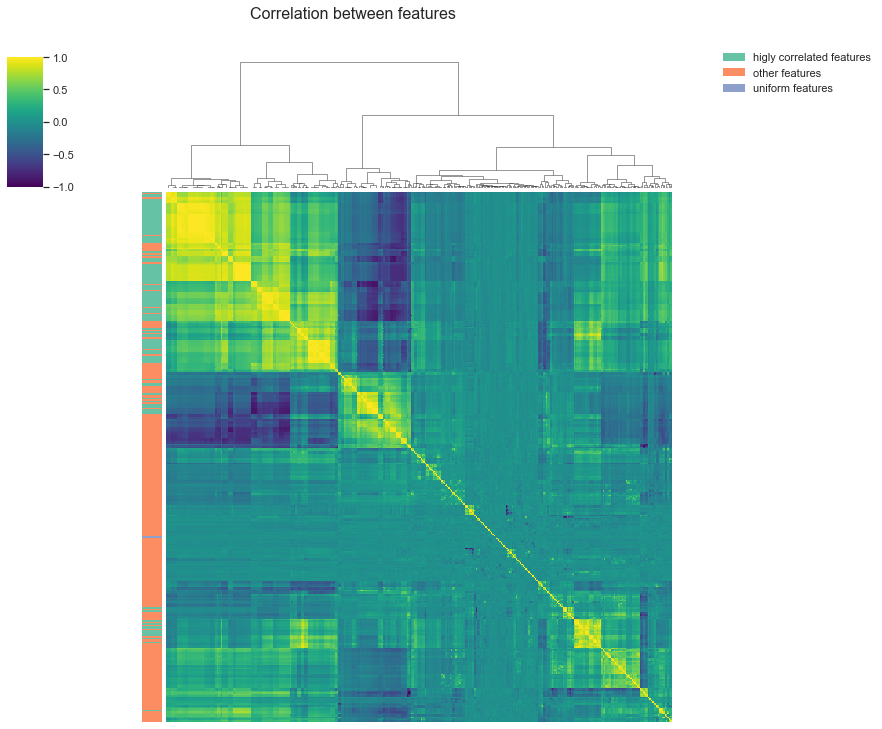

In [14]:
from morphelia.preprocessing import drop_highly_correlated

adata = drop_highly_correlated(adata, thresh=0.95, verbose=True, show=True)

### Batch correction

In [15]:
# batch correction
sc.pp.combat(adata, key="BatchNumber")

C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\scanpy\preprocessing\_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [16]:
adata

View of AnnData object with n_obs × n_vars = 3824 × 247
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Ce

### Identify highly variable features

In [17]:
sc.pp.highly_variable_genes(adata)

Trying to set attribute `.uns` of view, copying.


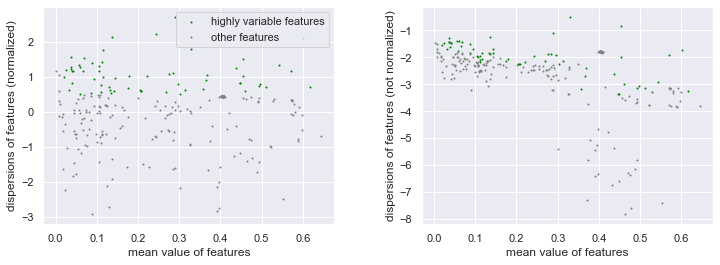

In [18]:
from morphelia.extern import highly_variable_genes

highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the scaled and logarithmized raw feature space
for later use in differential testing and visualizations. Thit simply freezes the state of the
AnnData object.

In [19]:
adata.raw = adata

Actually do the filtering

In [20]:
adata = adata[:, adata.var.highly_variable]

### Feature selection with Linear mixed models

In [21]:
from morphelia.stats import lmm_feat_select

adata = lmm_feat_select(adata, time_series=True, show=True)

ValueError: Only one category in fixed variables: ['Pe']
Categories (1, object): ['Pe'].

### Scale each feature to unit variance

In [22]:
adata = z_transform(adata, clip=10)

Trying to set attribute `.X` of view, copying.


### Feature agglomeration

C:\Users\amarx\PycharmProjects\Morphelia\morphelia\preprocessing\feature_agglo.py:48: UserWarning: Maximal expected k is larger than number of features
  warnings.warn("Maximal expected k is larger than number of features", UserWarning)
Testing 2 to 61 ks: 100%|██████████| 59/59 [00:00<00:00, 127.73it/s]


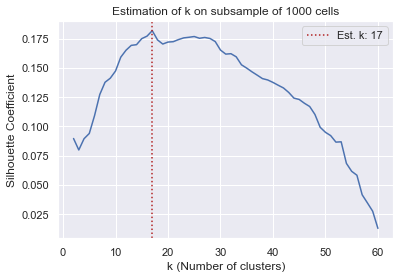

<Figure size 432x288 with 0 Axes>

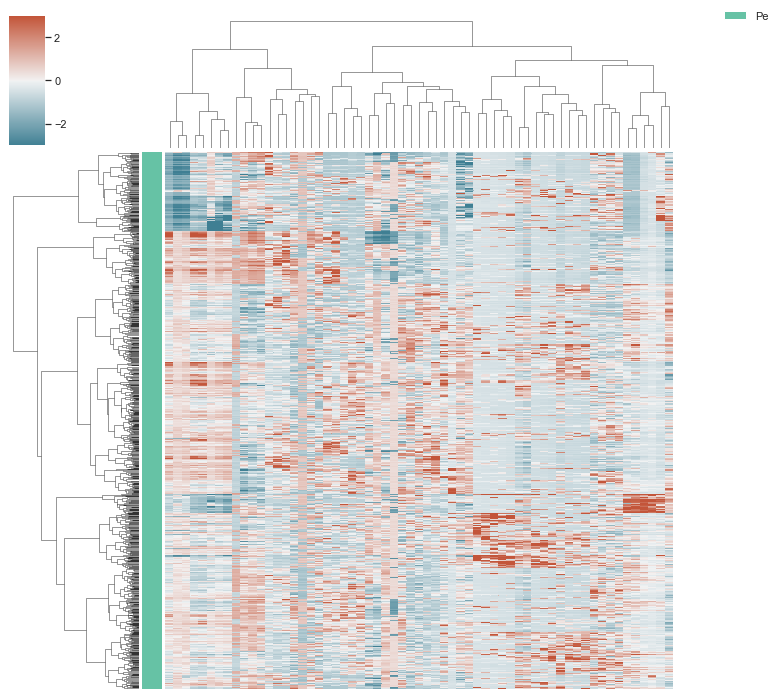

In [23]:
from morphelia.preprocessing import feature_agglo

adata = feature_agglo(adata, show=True, group_by='Metadata_Treatment', cluster_range=(2, 100))


In [24]:
adata.uns['agglo_feats']

{'agglo_2': ['Cells_RadialDistribution_ZernikePhase_CalceinAM_6_0',
  'Cells_AreaShape_Zernike_0_0',
  'Cells_AreaShape_Extent',
  'Cells_AreaShape_FormFactor'],
 'agglo_10': ['Cells_Neighbors_PercentTouching_Adjacent',
  'Cells_Neighbors_PercentTouching_20'],
 'agglo_9': ['Cells_Granularity_15_CalceinAM',
  'Cells_Granularity_14_CalceinAM',
  'Cells_Granularity_13_CalceinAM'],
 'agglo_1': ['Cells_Granularity_21_CalceinAM',
  'Cells_Granularity_20_CalceinAM',
  'Cells_Granularity_18_CalceinAM',
  'Cells_Granularity_25_CalceinAM',
  'Cells_Granularity_24_CalceinAM',
  'Cells_Granularity_23_CalceinAM',
  'Cells_Granularity_22_CalceinAM'],
 'agglo_15': ['Cells_Texture_DifferenceVariance_CalceinAM_20_00_256',
  'Cells_Texture_DifferenceVariance_CalceinAM_20_03_256',
  'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_00_256',
  'Cells_Texture_InverseDifferenceMoment_CalceinAM_20_02_256'],
 'agglo_7': ['Cells_Texture_DifferenceVariance_CalceinAM_10_02_256',
  'Cells_RadialDistribution_Fra

### Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA),
which reveals the main axes of variation and denoises the data.

In [25]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

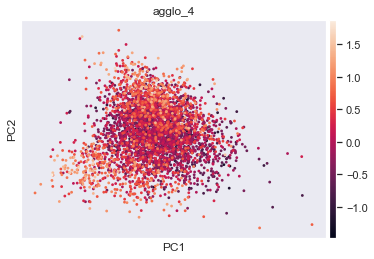

In [26]:
sc.pl.pca(adata, color='agglo_4')

In [27]:
adata.uns['pca']

{'params': {'zero_center': True, 'use_highly_variable': False},
 'variance': array([2.0094035 , 1.5330812 , 1.362768  , 0.94811195, 0.7947009 ,
        0.75767684, 0.6222949 , 0.57615477, 0.49865896, 0.44533473,
        0.33988997, 0.31585488, 0.21725962, 0.16247746, 0.14146322,
        0.11089157], dtype=float32),
 'variance_ratio': array([0.18363187, 0.14010255, 0.12453827, 0.0866444 , 0.07262474,
        0.06924126, 0.05686921, 0.05265263, 0.04557058, 0.04069747,
        0.03106127, 0.0288648 , 0.01985454, 0.01484821, 0.01292779,
        0.01013397], dtype=float32)}

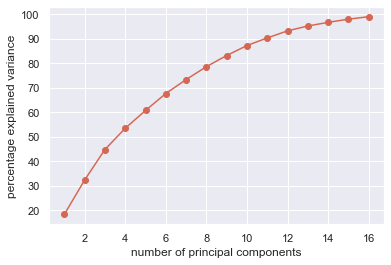

In [28]:
from morphelia.plotting import pca_variance_ratio

pca_variance_ratio(adata)

Let us inspect the contribution of single PCs to the total variance in the data.
This gives us information about how many PCs we should consider in order to
compute the neighborhood relations of cells, e.g. used in the clustering
function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough
estimate of the number of PCs does fine.

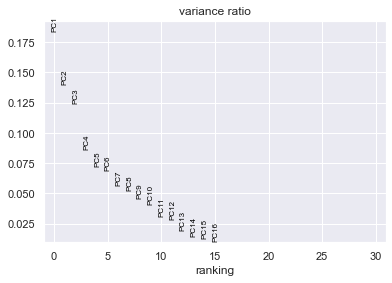

In [29]:
sc.pl.pca_variance_ratio(adata)

### Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA
representation of the data matrix. You might simply use default values here.

In [30]:
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=15)

### Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below.
It is potentially more faithful to the global connectivity of the manifold
than tSNE, i.e., it better preserves trajectories.
In some ocassions, you might still observe disconnected clusters and
similar connectivity violations. They can usually be remedied by running:

In [31]:
sc.tl.paga(adata)
sc.pl.paga(adata)

ValueError: You need to run `tl.leiden` or `tl.louvain` to compute community labels, or specify `groups='an_existing_key'`

In [33]:
sc.tl.umap(adata) #, init_pos='paga')

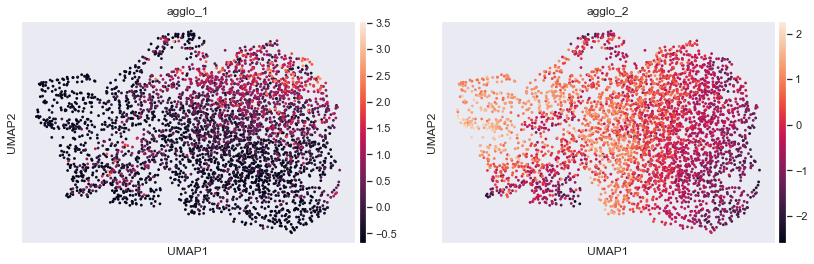

In [34]:
sc.pl.umap(adata, color=['agglo_1', 'agglo_2'])

As we set the .raw attribute of adata, the previous plots showed the “raw”
(normalized, logarithmized, but uncorrected) gene expression.
You can also plot the scaled and corrected gene expression by explicitly
stating that you don’t want to use .raw.



In [35]:
vars = adata.var.index.tolist()
len(vars)

17

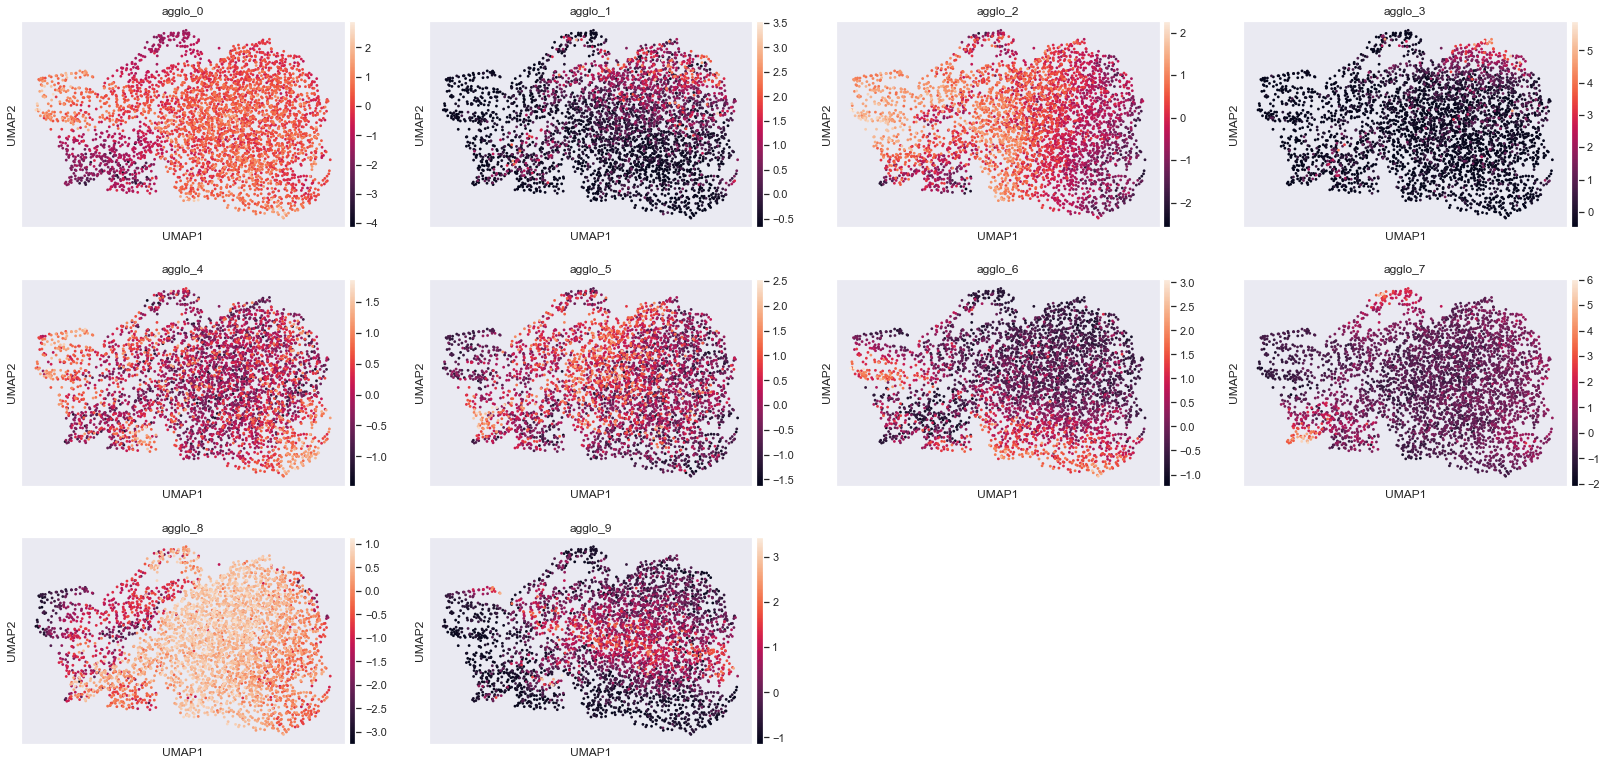

In [36]:
sc.pl.umap(adata, color=vars[:10],
           use_raw=False)

### Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden
graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018).
Note that Leiden clustering directly clusters the neighborhood graph of cells,
which we already computed in the previous section.

In [37]:
sc.tl.leiden(adata, resolution=0.2)

Plot the clusters, which agree quite well with the result of Seurat.

In [38]:
adata.obs['leiden']

0-0      1
1-0      1
2-0      0
3-0      1
4-0      0
        ..
689-8    0
690-8    1
691-8    0
692-8    2
693-8    1
Name: leiden, Length: 3824, dtype: category
Categories (5, object): ['0', '1', '2', '3', '4']

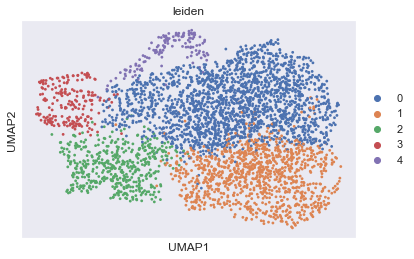

In [39]:
sc.pl.umap(adata, color='leiden')

### Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
For this, by default, the .raw attribute of AnnData is used in case it has been initialized before.
The simplest and fastest method to do so is the t-test.

C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


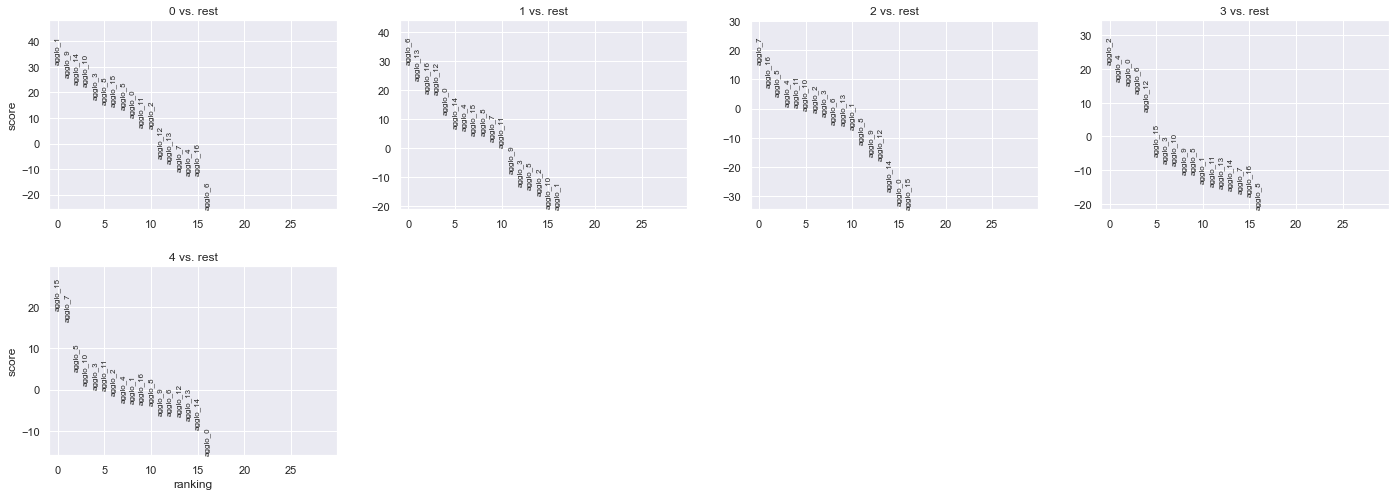

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

Show the 10 top ranked genes per cluster 0, 1, …, 4 in a dataframe.

In [41]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p
0,agglo_1,6.718297e-213,agglo_6,5.971244e-185,agglo_7,9.184530e-53,agglo_2,2.013081e-102,agglo_15,3.329455e-83
1,agglo_9,6.524900e-149,agglo_13,1.128740e-122,agglo_16,5.145729e-13,agglo_4,2.489349e-60,agglo_7,6.543360e-62
2,agglo_14,2.701555e-118,agglo_16,3.712670e-80,agglo_5,2.079532e-05,agglo_0,5.227172e-53,agglo_5,7.033810e-06
3,agglo_10,7.057674e-111,agglo_12,4.787264e-76,agglo_4,3.851090e-01,agglo_6,1.791535e-37,agglo_10,2.491081e-01
4,agglo_3,1.795745e-66,agglo_0,2.501202e-31,agglo_11,7.014622e-01,agglo_12,9.808414e-14,agglo_3,9.788069e-01


In [42]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4
0,agglo_1,agglo_6,agglo_7,agglo_2,agglo_15
1,agglo_9,agglo_13,agglo_16,agglo_4,agglo_7
2,agglo_14,agglo_16,agglo_5,agglo_0,agglo_5
3,agglo_10,agglo_12,agglo_4,agglo_6,agglo_10
4,agglo_3,agglo_0,agglo_11,agglo_12,agglo_3
5,agglo_8,agglo_14,agglo_10,agglo_15,agglo_11
6,agglo_15,agglo_4,agglo_2,agglo_3,agglo_2
7,agglo_5,agglo_15,agglo_3,agglo_10,agglo_4
8,agglo_0,agglo_8,agglo_6,agglo_9,agglo_1
9,agglo_11,agglo_7,agglo_13,agglo_5,agglo_16


Save the top features as marker features

In [43]:
marker_feats = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:1, :].values.flatten().tolist()
marker_feats

['agglo_1', 'agglo_6', 'agglo_7', 'agglo_2', 'agglo_15']

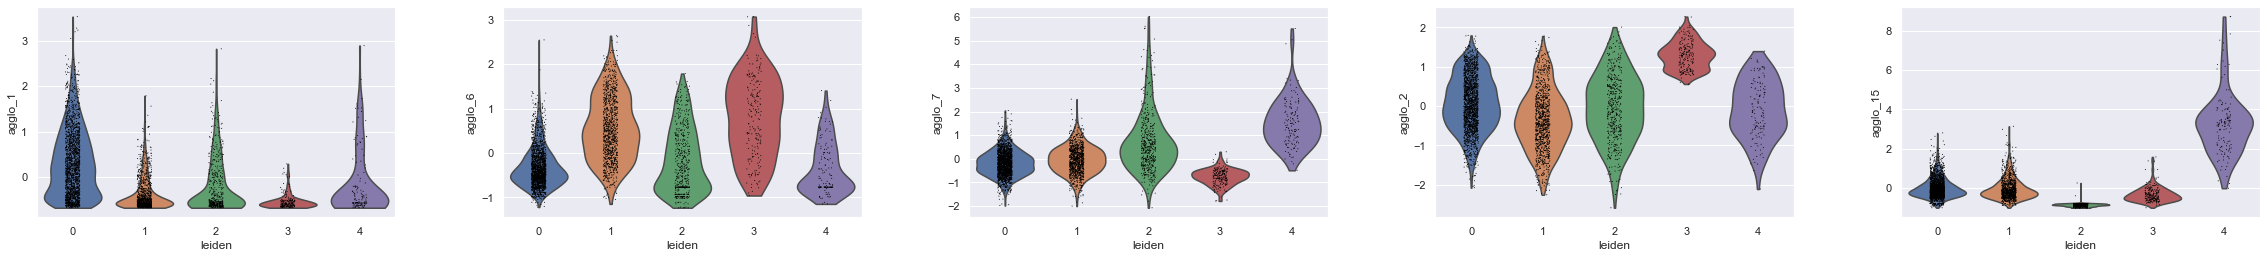

In [44]:
sc.pl.violin(adata, marker_feats, groupby='leiden')

In [45]:
mf = [m for m in marker_feats if m in adata.var_names]
mf

['agglo_1', 'agglo_6', 'agglo_7', 'agglo_2', 'agglo_15']

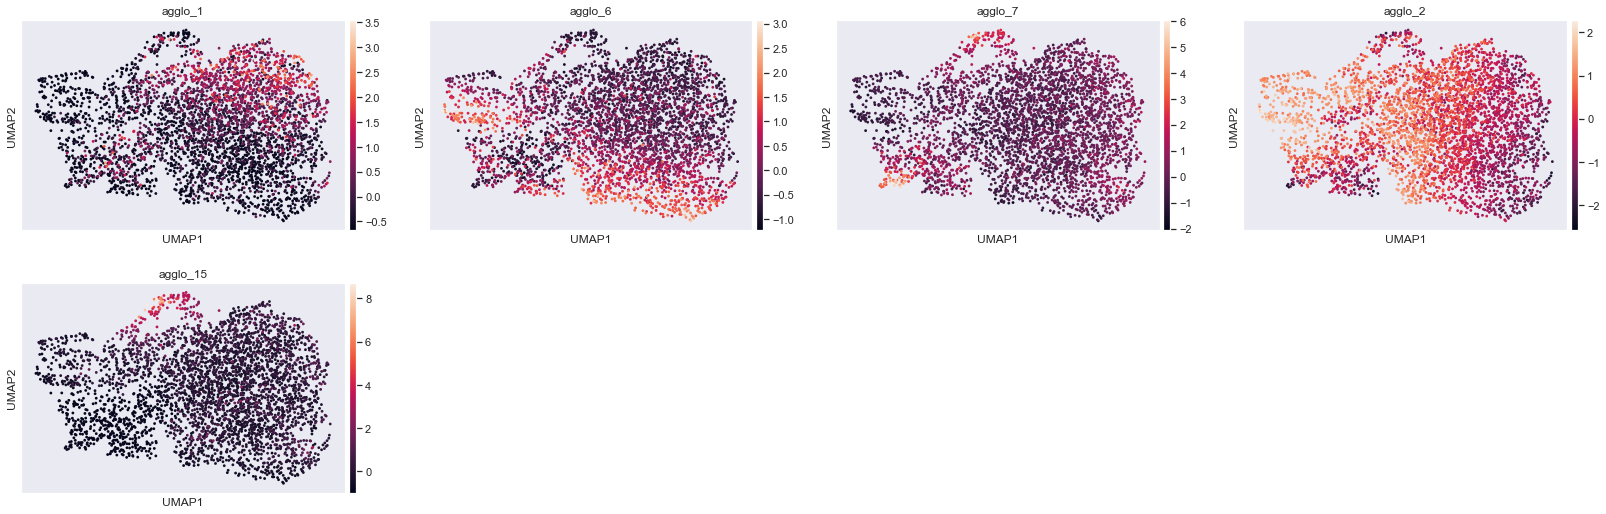

In [46]:
sc.pl.umap(adata, color=mf, use_raw=False)

### Trajectory

In [47]:
import scanpy.external as sce
import pandas as pd

In [48]:
adata.obs['Metadata_Time_Cat'] = pd.Categorical(adata.obs['Metadata_Time'].astype(str),
                                                categories=list(adata.obs['Metadata_Time'].astype(str).unique()))

In [49]:
sce.tl.harmony_timeseries(adata, tp='Metadata_Time_Cat', n_components=10)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Running PCA with 9 components
Nearest neighbor computation...


C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\harmony\core.py:70: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  kNN = temp.uns['neighbors']['distances']


Constucting affinities between 0 and 3...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 3 and 6...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 6 and 9...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 9 and 12...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 12 and 24...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 24 and 30...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 30 and 36...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between 36 and 48...
t+1 neighbors of t...
t neighbors of t+1...


100%|██████████| 500/500 [01:47<00:00,  4.64it/s]

BarnesHut Approximation  took  21.64  seconds
Repulsion forces  took  78.69  seconds
Gravitational forces  took  0.48  seconds
Attraction forces  took  2.80  seconds
AdjustSpeedAndApplyForces step  took  2.01  seconds


In [50]:
adata

AnnData object with n_obs × n_vars = 3824 × 17
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neigh

In [51]:
sce.tl.palantir(adata,
                n_components=5,
                knn=30,
                use_adjacency_matrix=True,
                distances_key='harmony_aff_aug')

In [52]:
sc.tl.tsne(adata, use_rep='X_palantir_multiscale')

In [53]:
adata.var_names

Index(['agglo_0', 'agglo_1', 'agglo_2', 'agglo_3', 'agglo_4', 'agglo_5',
       'agglo_6', 'agglo_7', 'agglo_8', 'agglo_9', 'agglo_10', 'agglo_11',
       'agglo_12', 'agglo_13', 'agglo_14', 'agglo_15', 'agglo_16'],
      dtype='object')

C:\Users\amarx\Anaconda3\envs\morphelia_env\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


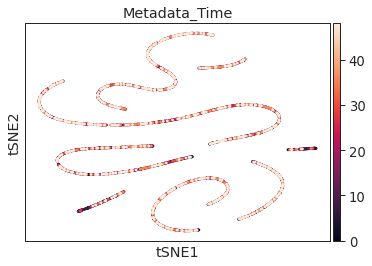

In [57]:
sc.pl.tsne(adata, color="Metadata_Time")

In [66]:
adata

AnnData object with n_obs × n_vars = 3824 × 17
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neigh

In [62]:
start_cell = '0-0'
pr_res = sce.tl.palantir_results(
    adata,
    early_cell=start_cell,
    ms_data='X_palantir_multiscale',
    num_waypoints=500,
)

KeyError: 'alex'

In [61]:
pr_res.branch_probs

,51-4
0-0,1.0
1-0,1.0
2-0,1.0
3-0,1.0
4-0,1.0
...,...
689-8,1.0
690-8,1.0
691-8,1.0
692-8,1.0


In [63]:
import palantir

AttributeError: 'numpy.ndarray' object has no attribute 'index'

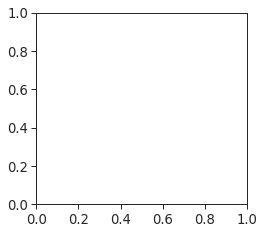

In [67]:
gene_trends = palantir.plot.plot_palantir_results(pr_res, adata.obsm['X_tsne'])

In [68]:
adata

AnnData object with n_obs × n_vars = 3824 × 17
    obs: 'BatchNumber', 'PlateNumber', 'ImageNumber', 'ObjectNumber', 'Metadata_Col', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Row', 'Metadata_Series', 'Metadata_Well', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X', 'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y', 'Cells_AreaShape_EulerNumber', 'Cells_Location_CenterMassIntensity_X_CalceinAM', 'Cells_Location_CenterMassIntensity_Y_CalceinAM', 'Cells_Location_CenterMassIntensity_Z_CalceinAM', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_CalceinAM', 'Cells_Location_MaxIntensity_Y_CalceinAM', 'Cells_Location_MaxIntensity_Z_CalceinAM', 'Cells_Neighbors_FirstClosestObjectNumber_20', 'Cells_Neighbors_FirstClosestObjectNumber_Adjacent', 'Cells_Neigh

In [70]:
adata.obsp['connectivities']

<3824x3824 sparse matrix of type '<class 'numpy.float32'>'
	with 39812 stored elements in Compressed Sparse Row format>